# Optimization Problem Time Series

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
# from pulp import LpVariable, LpProblem, lpSum, LpMinimize, LpStatus
from pulp import *
# Importing functions 
from utilities import import_excel
# from Class_time_serie import Time_serie
import plotly.graph_objects as go


In [2]:
import gurobipy as gp

options = {
    "WLSACCESSID":"1b1f64ca-fe52-4c0c-bf3f-74d35bd43d51",
    "WLSSECRET":"431b8c8e-287c-476c-849c-b206b4e81924",
    "LICENSEID":2503220,
}

### Load Time Series

In [3]:
# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years

# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 24 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

# Directory path
path_input_data = '../input_time_series/'
# file_name = 'France/France_load_entsoe_2021.xlsx'
file_name = 'California/California_2021_hourly_demand_MWh.xlsx'

Load_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

mean_load = pd.read_excel(path_input_data+file_name).mean().iloc[0]

In [4]:

# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 4 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 24 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = '../input_time_series/'
# file_name = 'France/Wind_onshore_energy_France_2021_intermittent.xlsx'
file_name = 'California/Wind_onshore_energy_California_2021_intermittent.xlsx'
Wind_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day
mean_wind = pd.read_excel(path_input_data+file_name).mean().iloc[0]

In [5]:

# Specipy the number of data per day of your time serie : dpd
# Specipy the number of day per year of your time serie : dpy
dpd = 24 # data per day
dpy = 365 # data per year :  cut the leap years to 365 years


# Signals can then be interpotated (within import_excel function)to a greater number of data per day (ndpd).This is useful for the wavelet decomposition to obtain daughter wavelets of th proper length.
ndpd = 24 # new data per year (for the interpolation). Minimum number so that the shortes wavelet has 2 data.
signal_length = ndpd * dpy

#
# Directory path
path_input_data = '../input_time_series/'

# file_name = 'France/Solar_energy_France_2021_intermittent.xlsx'
file_name='California/California_2021_hourly_solar_MWh.xlsx'
PV_ts = import_excel(path_input_data,file_name, 
                                    dpd ,ndpd, dpy, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day
mean_pv =  pd.read_excel(path_input_data+file_name).mean().iloc[0]

### Parameters of the problem

In [10]:
tolerance_list= [0.001, 0.01,0.008, 0.005, 0.002, 0.0001]
tolerance_list = [0.005, 0.002, 0.0001]
file_path = "optimization_tolerance_CAL.txt"
with open(file_path, "a") as file:
    for bound in tolerance_list: 
        print(bound)
        prob = LpProblem("myProblem", LpMinimize)
        signal_length = len(Load_ts)
        dt = 1 #heure
        e_factor = 10 #nombre d'heures de consommation
        stock_efficiency = 0.8 #pourcentage
        E_max = e_factor*Load_ts.mean()
        P_max = 100000 #MW
        SOC_ini = 0

        # Variables de décision
        x_pv = LpVariable("PV_coefficient", lowBound=0)
        x_wind = LpVariable("Wind_coefficient", lowBound=0)
        ts_dispatchable = LpVariable.dicts('Dispatchable_production', range(signal_length), lowBound=0 )
        p_ch = LpVariable.dicts('Pch', range(signal_length), lowBound=0, upBound = P_max)
        p_dech = LpVariable.dicts('Pdech', range(signal_length), lowBound=0, upBound = P_max)
        SOC_ts = LpVariable.dicts('Stock',range(signal_length), lowBound=0, upBound=E_max )
        #TODO : changer upBound curtailment
        p_curt = LpVariable.dicts('Curtailment',range(signal_length), lowBound=0, upBound=0.1)
        p_stock = LpVariable.dicts('Pstock',range(signal_length), lowBound=-P_max, upBound=P_max)
        dech_active = LpVariable.dicts('Dech_active', range(signal_length), cat='Binary')


        # Contrainte 1 : Loi des noeuds
        for t in range(len(Load_ts)):
            prob += x_pv * PV_ts[t] + ts_dispatchable[t] + x_wind * Wind_ts[t]+p_dech[t] == Load_ts[t]  +p_ch[t]+p_curt[t]

        # Contrainte 2 : stockage et déstockage
        for t in range(1, signal_length):
            prob += SOC_ts[t] == SOC_ts[t-1] + (stock_efficiency*p_ch[t]-p_dech[t])*dt

            # Utilisation de la variable binaire pour contrôler le déchargement ou le chargement
            prob += p_ch[t] <= (1-dech_active[t])*P_max #not chagre and discharge at the same time
            prob += p_dech[t] <= (dech_active[t])*P_max

        #TODO : trouver une mailleure contrainte pour p_stock
        # prob += p_stock[0]==0
        prob+= p_ch[0]==0
        prob+=p_dech[0]==0
        prob += SOC_ts[0] == SOC_ts[signal_length-1] #same state of charge at the start and end
        prob += x_pv + x_wind <= Load_ts.mean()



        # Fonction objectif
        prob += lpSum(ts_dispatchable.values())*dt


        prob.solve(GUROBI(gapRel = bound))

        
        # Write the status of the optimization
        file.write("Status: " + LpStatus[prob.status] + "\n")
        file.write("Tolerance: " + str(bound)+ "\n")
        # Write the optimal values of the coefficients for PV and wind
        file.write("Optimal coefficient for PV: " + str(x_pv.varValue) + "\n")
        file.write("Optimal coefficient for Wind: " + str(x_wind.varValue) + "\n")


0.005
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2503220 - for non-commercial use only - registered to du___@ethz.ch
Optimize a model with 35041 rows, 52561 columns and 122623 nonzeros
Model fingerprint: 0xef1f27d0
Variable types: 43802 continuous, 8759 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e+05]
  RHS range        [6e-01, 1e+05]
Found heuristic solution: objective 8760.0000000
Presolve removed 4 rows and 8764 columns
Presolve time: 2.39s
Presolved: 35037 rows, 43797 columns, 115025 nonzeros
Variable types: 35038 continuous, 8759 integer (8759 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing pr

In [ ]:
dispatch_ts = pd.DataFrame(np.array(optimized_dispatchable)*mean_load)
dispatch_ts.to_excel('results_optim/California/dispatchable_CAL.xlsx', index = False)

In [ ]:
state_of_charge_ts = pd.DataFrame(np.array(optimized_stock)*mean_load)
state_of_charge_ts.to_excel('results_optim/California/SOC_CAL.xlsx', index = False)

In [ ]:
curt_ts = pd.DataFrame(np.array(optimized_p_curt_ts)*mean_load)
disp_minus_curt = dispatch_ts-curt_ts
state_of_charge_ts.to_excel('results_optim/California/disp_minus_curt_CAL.xlsx', index = False)

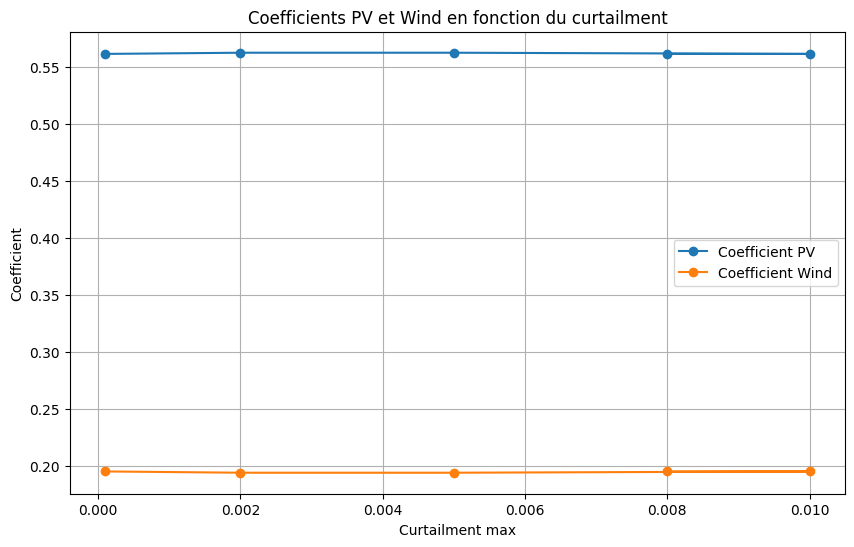

In [14]:
import matplotlib.pyplot as plt

# Initialisation des listes pour stocker les données
curtailment_max = []
coeff_pv = []
coeff_wind = []

# Lecture du fichier texte
with open('optimization_tolerance_CAL.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith('Tolerance'):
            curtailment_max.append(float(line.split(': ')[1]))
        elif line.startswith('Optimal coefficient for PV'):
            coeff_pv.append(float(line.split(': ')[1]))
        elif line.startswith('Optimal coefficient for Wind'):
            coeff_wind.append(float(line.split(': ')[1]))

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(curtailment_max, coeff_pv, marker='o', label='Coefficient PV')
plt.plot(curtailment_max, coeff_wind, marker='o', label='Coefficient Wind')
plt.xlabel('Curtailment max')
plt.ylabel('Coefficient')
plt.title('Coefficients PV et Wind en fonction du curtailment')
plt.legend()
plt.grid(True)
plt.show()


In [136]:
# # Specify the file path
# file_path = "optimization_results_CAL_1704_1.txt"

# # Open the file in write mode
# with open(file_path, "w") as file:
#     # Write the status of the optimization
#     file.write("Status: " + LpStatus[prob.status] + "\n")
#     # Write the optimal values of the coefficients for PV and wind
#     file.write("Optimal coefficient for PV: " + str(x_pv.varValue) + "\n")
#     file.write("Optimal coefficient for Wind: " + str(x_wind.varValue) + "\n")

#     # Write the values of p_ch, p_dech, and dech_active for each time step
#     for t in range(signal_length):
#         file.write("Time step: " + str(t) + "\n")
#         file.write("p_curt: " + str(p_curt[t].varValue) + "\n")
#         file.write("dech_active: " + str(dech_active[t].varValue) + "\n")

In [137]:

# Récupérer les valeurs optimales des coefficients
optimal_pv_coefficient = x_pv.varValue
optimal_wind_coefficient = x_wind.varValue

optimized_pv = [optimal_pv_coefficient * PV_ts[t] for t in range(signal_length)]
optimized_wind = [optimal_wind_coefficient * Wind_ts[t] for t in range(signal_length)]
optimized_dispatchable = [ts_dispatchable[t].varValue for t in range(signal_length)]
optimized_stock = [SOC_ts[t].varValue for t in range(signal_length)]
optimized_p_curt_ts = [p_curt[t].varValue for t in range(signal_length)]
optimized_charge = [p_ch[t].varValue for t in range(signal_length)]
optimized_discharge = [p_dech[t].varValue for t in range(signal_length)]

In [141]:
fig = go.Figure()

# Ajouter les traces de données
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_pv, mode='lines', name='PV', stackgroup = 'stacked'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_wind, mode='lines', name='Wind', stackgroup = 'stacked'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_dispatchable, mode='lines', name='Dispatchable'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=Load_ts, mode='lines', name='Consumption'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_stock, mode='lines', name='Stock'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_charge, mode='lines', name='Charge'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_discharge, mode='lines', name='Discharge'))
# fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_p_dech_ts, mode='lines', name='Discharge'))
# fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_p_ch_ts, mode='lines', name='Charge'))
fig.add_trace(go.Scatter(x=list(range(signal_length)), y=optimized_p_curt_ts, mode='lines', name='Curtailment'))
# Modifier les axes et le titre
fig.update_layout(
    xaxis_title='Time Step',
    yaxis_title='Production / Consumption',
    title='Optimized Production and Consumption'
)
# fig.update_traces(fill='tozeroy', mode='lines', line=dict(width=0))
fig.write_html("CAL_optim_1704_2.html")
# Afficher la figure
fig.show()

## Diagrammes et graphes

In [139]:
# Bar chart

E_wind = np.sum(optimized_wind)*mean_load
E_pv = np.sum(optimized_pv)*mean_load
E_dispatch = np.sum(optimized_dispatchable)*mean_load
E_curt = -np.sum(optimized_p_curt_ts)*mean_load
E_loss  = -(np.sum(optimized_charge)-np.sum(optimized_discharge))*mean_load
E_stock = np.sum(optimized_charge)*mean_load
E_destock = np.sum(optimized_discharge)*mean_load

In [142]:
# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Wind', x=['Energy Production'], y=[E_wind]),
    go.Bar(name='PV', x=['Energy Production'], y=[E_pv]),
    go.Bar(name='Dispatchable', x=['Energy Production'], y=[E_dispatch]),
    go.Bar(name='Curtailment', x=['Energy Production'], y=[E_curt]),
    go.Bar(name='Loss', x=['Energy Production'], y=[E_loss])
])

# Update layout
fig.update_layout(
    title='Energy Production',  # stack bars on top of each other
    barmode='relative',
    yaxis_title='MWh'  # y-axis label
)
fig.write_html("CAL_bar_chart_1704_2.html")
fig.show()

In [143]:

fig = go.Figure(data=[
    go.Bar(name='Wind', x=['California'], y=[E_wind]),
    go.Bar(name='PV', x=['California'], y=[E_pv]),
    go.Bar(name='Dispatchable', x=['California'], y=[E_dispatch]),
    go.Bar(name='Curtailment', x=['California'], y=[E_curt]),
    go.Bar(name='Loss', x=['California'], y=[E_loss])
])

fig.update_layout(
    title='Energy production',
    barmode='relative',
    yaxis_title = 'MWh'
)

fig.show()

In [144]:
# Pie chart

fig = go.Figure(data=[go.Pie(labels=['Wind', 'PV', 'Dispatchable'],
                             values=[E_wind, E_pv, E_dispatch])])


fig.update_layout(title='Energy Production')
fig.write_html("CAL_pie_1704_2.html")
fig.show()

In [145]:
# Bar chart

E_wind = np.sum(optimized_wind)*mean_load
E_pv = np.sum(optimized_pv)*mean_load
E_dispatch = np.sum(optimized_dispatchable)*mean_load
E_curt = np.sum(optimized_p_curt_ts)*mean_load
E_loss  =(np.sum(optimized_charge)-np.sum(optimized_discharge))*mean_load
E_stock = np.sum(optimized_charge)*mean_load
E_destock = np.sum(optimized_discharge)*mean_load

In [147]:
# Sankey

sources = ['Wind', 'PV', 'Dispatchable','Production', 'Consumption', 'Loss', 'Curtailment']
E_production = E_wind + E_pv + E_dispatch
E_consumption = Load_ts.mean()

# Définition des valeurs d'énergie pour chaque source
values = [E_wind, E_pv, E_dispatch, E_production, E_consumption, E_loss, E_curt]  # Assurez-vous que la somme est égale à 100 ou à la valeur totale d'énergie

# Création des liens entre les sources
link_source = [0, 1, 2, 3, 3,  3]  # Les index 0, 1 et 2 représentent les sources Wind, PV et Dispatchable, respectivement.
link_target = [3, 3, 3, 4, 5, 6, 7 ]  # L'index 3 représente la source "Output"
link_value = values  # Les valeurs sont celles des énergies calculées
colors = ['rgba(31, 119, 180, 0.8)', 'rgba(255, 127, 14, 0.8)', 'rgba(44, 160, 44, 0.8)', 'rgba(214, 39, 40, 0.8)', 
          'rgba(148, 103, 189, 0.8)', 'rgba(140, 86, 75, 0.8)', 'rgba(227, 119, 194, 0.8)', 'rgba(127, 127, 127, 0.8)','rgba(44, 160, 44, 0.8)' ]

# Création du Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=sources,
      color=colors
    ),
    link=dict(
      source=link_source,
      target=link_target,
      value=link_value
  ))])

# Mise en forme du layout
fig.update_layout(title_text="Energy Distribution Sankey Diagram (Reversed)")
fig.write_html("CAL_sankey_1704_2.html")
# Afficher le diagramme
fig.show()

## Sauvegarder les time series pour la décomposition en ondelettes

In [124]:
dispatch_ts = pd.DataFrame(np.array(optimized_dispatchable)*mean_load)
dispatch_ts.to_excel('results_optim/California/dispatchable_CAL.xlsx', index = False)

In [125]:
state_of_charge_ts = pd.DataFrame(np.array(optimized_stock)*mean_load)
state_of_charge_ts.to_excel('results_optim/California/SOC_CAL.xlsx', index = False)

In [126]:
curt_ts = pd.DataFrame(np.array(optimized_p_curt_ts)*mean_load)
disp_minus_curt = dispatch_ts-curt_ts
state_of_charge_ts.to_excel('results_optim/California/disp_minus_curt_CAL.xlsx', index = False)